In [127]:
import os

#HOME_DIR = '/Users/yoav/Documents/Yoav/CS/20936 - DS Project/Shotpred'
HOME_DIR = '/Users/home/Shotpred'

DATA_DIR = os.path.join(HOME_DIR, 'data')
EXT_DATA_DIR = os.path.join(DATA_DIR, 'External')
INT_DATA_DIR = os.path.join(DATA_DIR, 'Internal')

import sys
sys.path.append("/Users/home/Shotpred/utils")
#sys.path.append("/Users/yoav/Documents/Yoav/CS/20936 - DS Project/Shotpred/utils")

In [129]:
import pandas as pd
import os
from nba_api.stats.endpoints import playerindex, playbyplayv3

import data_utils as du

import importlib
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [9]:
KAGGLE_SHOT_LOGS_201415_FILENAME = 'kaggle_shot_logs_2014_15.csv'
KAGGLE_SHOT_LOGS_201415_FULLPATH = os.path.join(EXT_DATA_DIR, KAGGLE_SHOT_LOGS_201415_FILENAME)

GENERAL_SHOT_LOGS_FILENAME = 'nba_2015_shots.csv'
GENERAL_SHOT_LOGS_FULLPATH = os.path.join(EXT_DATA_DIR, GENERAL_SHOT_LOGS_FILENAME)

In [10]:
KAGGLE_COLS_FOR_MERGE = ['GAME_ID', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id', 'absolute_game_time']
CAREER_STATS_COL_FOR_MERGE = ['PLAYER_ID', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT'] #already filtered for relevant season

In [11]:
shot_logs_1415 = pd.read_csv(KAGGLE_SHOT_LOGS_201415_FULLPATH)

In [12]:
active_players_201415_ids = shot_logs_1415['player_id'].unique()

In [13]:
shot_logs_1415['absolute_game_time'] = shot_logs_1415.apply(lambda row: du.clock_to_absolute_seconds(row['GAME_CLOCK'], row['PERIOD']), axis=1)

In [14]:
#active_players_career_stats = du.gather_mul_career_stats(active_players_201415_ids) # get the career stats for all active players in 2014-15 season

In [15]:
#active_players_cs_in_1415 = active_players_career_stats[active_players_career_stats['SEASON_ID'] == '2014-15'].reset_index(drop=True)
#active_players_cs_in_1415.to_csv(INT_DATA_DIR + 'active_players_career_stats_2014_15.csv', index=False)

In [16]:
active_players_cs_in_1415 = pd.read_csv(os.path.join(INT_DATA_DIR, 'active_players_career_stats_2014_15.csv'))

In [17]:
gen_sl = pd.read_csv(GENERAL_SHOT_LOGS_FULLPATH)

In [18]:
gen_sl['absolute_game_time'] = gen_sl.apply(lambda row: du.clock_to_absolute_seconds(f"{str(row["MINS_LEFT"]).zfill(2)}:{str(row["SECS_LEFT"]).zfill(2)}", row['QUARTER']), axis=1)

In [19]:
kaggle_for_join = shot_logs_1415[KAGGLE_COLS_FOR_MERGE]

In [20]:
kaggle_for_join.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time
0,21400899,10.8,2,1.9,"Anderson, Alan",101187,1.3,203148,651.0
1,21400899,3.4,0,0.8,"Bogdanovic, Bojan",202711,6.1,203148,706.0
2,21400899,NaN,3,2.7,"Bogdanovic, Bojan",202711,0.9,203148,720.0
3,21400899,10.3,2,1.9,"Brown, Markel",203900,3.4,203148,733.0
4,21400899,10.9,2,2.7,"Young, Thaddeus",201152,1.1,203148,806.0


In [21]:
gen_sl_game_ids = set(gen_sl['GAME_ID'].unique())
kaggle_for_join_game_ids = set(kaggle_for_join['GAME_ID'].unique())

common_game_ids = gen_sl_game_ids.intersection(kaggle_for_join_game_ids)

print(f"Number of unique GAME_IDs in gen_sl: {len(gen_sl_game_ids)}")
print(f"Number of unique GAME_IDs in kaggle_for_join: {len(kaggle_for_join_game_ids)}")
print(f"Number of common GAME_IDs in both: {len(common_game_ids)}")

Number of unique GAME_IDs in gen_sl: 1230
Number of unique GAME_IDs in kaggle_for_join: 904
Number of common GAME_IDs in both: 904


In [22]:
kaggle_for_join = kaggle_for_join.sort_values(by=['absolute_game_time']).reset_index(drop=True)

In [23]:
gen_sl = gen_sl.sort_values(by=['absolute_game_time']).reset_index(drop=True)
gen_sl['gen_sl_time_copy'] = gen_sl['absolute_game_time']

In [24]:
merged = pd.merge_asof(kaggle_for_join, gen_sl, on='absolute_game_time',left_by=['player_id', 'GAME_ID'], right_by=['PLAYER_ID', 'GAME_ID'],  direction='nearest', suffixes=['_kaggle', '_shot_logs'], tolerance=5) #,left_by=['player_id', 'GAME_ID'], right_by=['PLAYER_ID', 'GAME_ID'], 

In [25]:
merged

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,Center,C,Less Than 8 ft.,-0.6,5.35,0.0,1.0,11.0,54.0,6.0
1,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,Center,C,Less Than 8 ft.,-2.4,5.05,2.0,1.0,11.0,52.0,8.0
2,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,Center,C,Less Than 8 ft.,1.5,6.45,1.0,1.0,11.0,51.0,9.0
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,Center,C,Less Than 8 ft.,-2.2,6.65,2.0,1.0,11.0,54.0,6.0
4,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,Center,C,Less Than 8 ft.,-0.0,5.35,0.0,1.0,11.0,55.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400164,8.0,0,0.8,"Ilyasova, Ersan",101141,6.6,202711,5018.0,2015.0,...,Left Side Center,LC,24+ ft.,11.1,26.95,24.0,7.0,0.0,19.0,5021.0
128065,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,2015.0,...,Left Side,L,16-24 ft.,19.4,11.65,20.0,7.0,0.0,17.0,5023.0
128066,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,2015.0,...,Right Side,R,16-24 ft.,-16.6,4.95,16.0,7.0,0.0,7.0,5033.0
128067,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,2015.0,...,Right Side Center,RC,24+ ft.,-13.3,29.35,27.0,7.0,0.0,3.0,5037.0


In [26]:
not_merged = merged[merged.gen_sl_time_copy.isna()]

In [27]:
not_merged.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy
182,21400345,11.6,2,5.0,"Conley, Mike",201144,0.3,203487,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,21400471,22.9,0,2.1,"Hill, Jordan",201941,2.6,202389,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,21400872,11.2,0,0.0,"Amundson, Lou",200811,3.7,202685,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,21400322,10.9,0,4.6,"Joseph, Cory",202709,2.9,101181,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
379,21400515,9.6,5,4.1,"Holiday, Jrue",201950,5.7,202322,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
heights = pd.read_csv(os.path.join(INT_DATA_DIR, 'nba_2014_2015_player_heights_with_ids.csv'))

In [29]:
heights

,PLAYER_NAME,HEIGHT,PLAYER_ID
0,AJ Price,6-2,201985.0
1,Aaron Brooks,6-0,201166.0
2,Aaron Gordon,6-8,203932.0
3,Adreian Payne,6-10,203940.0
4,Al Horford,6-9,201143.0
...,...,...,...
479,Xavier Henry,6-6,202333.0
480,Zach LaVine,6-5,203897.0
481,Zach Randolph,6-9,2216.0
482,Zaza Pachulia,6-11,2585.0


In [30]:
# Merge for attacker heights
merged_with_attacker_heights = pd.merge(merged, heights, left_on='PLAYER_NAME', right_on='PLAYER_NAME', suffixes=('', '_attacker'))

# !!!!!!Merge for defender heights - CAUSES NULL VALUES BECAUSE OF THE DIFFERENT PLAYER NAMES AND LEFT JOIN - NEED IDS!!!!!
merged_with_both_heights = pd.merge(merged_with_attacker_heights, heights, left_on='CLOSEST_DEFENDER_PLAYER_ID', right_on='PLAYER_ID', suffixes=('', '_defender'), how='left')

# Drop the extra PLAYER_NAME column from the second merge
merged_with_both_heights = merged_with_both_heights.drop(columns=['PLAYER_NAME_defender'])

merged_with_both_heights

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy,HEIGHT,PLAYER_ID_attacker,HEIGHT_defender,PLAYER_ID_defender
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,5.35,0.0,1.0,11.0,54.0,6.0,6-4,2754.0,6-2,202709.0
1,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,5.05,2.0,1.0,11.0,52.0,8.0,6-8,2772.0,6-6,201960.0
2,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,6.45,1.0,1.0,11.0,51.0,9.0,6-9,202693.0,6-3,201565.0
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,6.65,2.0,1.0,11.0,54.0,6.0,6-3,203463.0,6-6,203095.0
4,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,5.35,0.0,1.0,11.0,55.0,5.0,6-9,202693.0,6-11,201586.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124542,21400375,6.3,17,17.7,"Duncan, Tim",1495,5.0,201144,5017.0,2015.0,...,22.85,17.0,7.0,0.0,20.0,5020.0,6-0,201144.0,6-11,1495.0
124543,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,2015.0,...,11.65,20.0,7.0,0.0,17.0,5023.0,6-5,201584.0,6-11,1495.0
124544,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,2015.0,...,4.95,16.0,7.0,0.0,7.0,5033.0,6-7,2207.0,6-11,203507.0
124545,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,2015.0,...,29.35,27.0,7.0,0.0,3.0,5037.0,6-6,1938.0,6-11,201188.0


In [31]:
COLS_FOR_PRED = ['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'absolute_game_time', 'SEASON_1', 'SEASON_2', 'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM', 'SHOT_MADE', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'HEIGHT', 'HEIGHT_defender']
COLS_FOR_PRED.extend(CAREER_STATS_COL_FOR_MERGE)

# interchange SEASON1/SEASON2
# maybe the game date is highly correlated with season so leave only game date
# probably need to chose only subset of the game time/qtr/mins_left/secs_left features
# SHOT_MADE and EVENT_TYPE is g.t

In [32]:
cs_for_merge = active_players_cs_in_1415[CAREER_STATS_COL_FOR_MERGE]
for_pred = pd.merge(merged_with_both_heights, cs_for_merge, on='PLAYER_ID')

In [33]:
#for_pred.head(1000).to_csv(os.path.join(INT_DATA_DIR, 'for_pred.csv'), index=False)

In [34]:
for_pred[COLS_FOR_PRED].columns

Index(['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'absolute_game_time', 'SEASON_1', 'SEASON_2',
       'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE',
       'HOME_TEAM', 'AWAY_TEAM', 'SHOT_MADE', 'ACTION_TYPE', 'BASIC_ZONE',
       'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y',
       'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'HEIGHT',
       'HEIGHT_defender', 'PLAYER_ID', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT'],
      dtype='object')

In [35]:
def visualize_distributions(df):
    """
    Create visualizations for data distributions
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = numerical_cols.drop(['PLAYER_ID', 'CLOSEST_DEFENDER_PLAYER_ID', 'SEASON_1'])
    
    # Distribution plots for numerical columns
    plt.figure(figsize=(15, 5 * (len(numerical_cols) // 3 + 1)))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

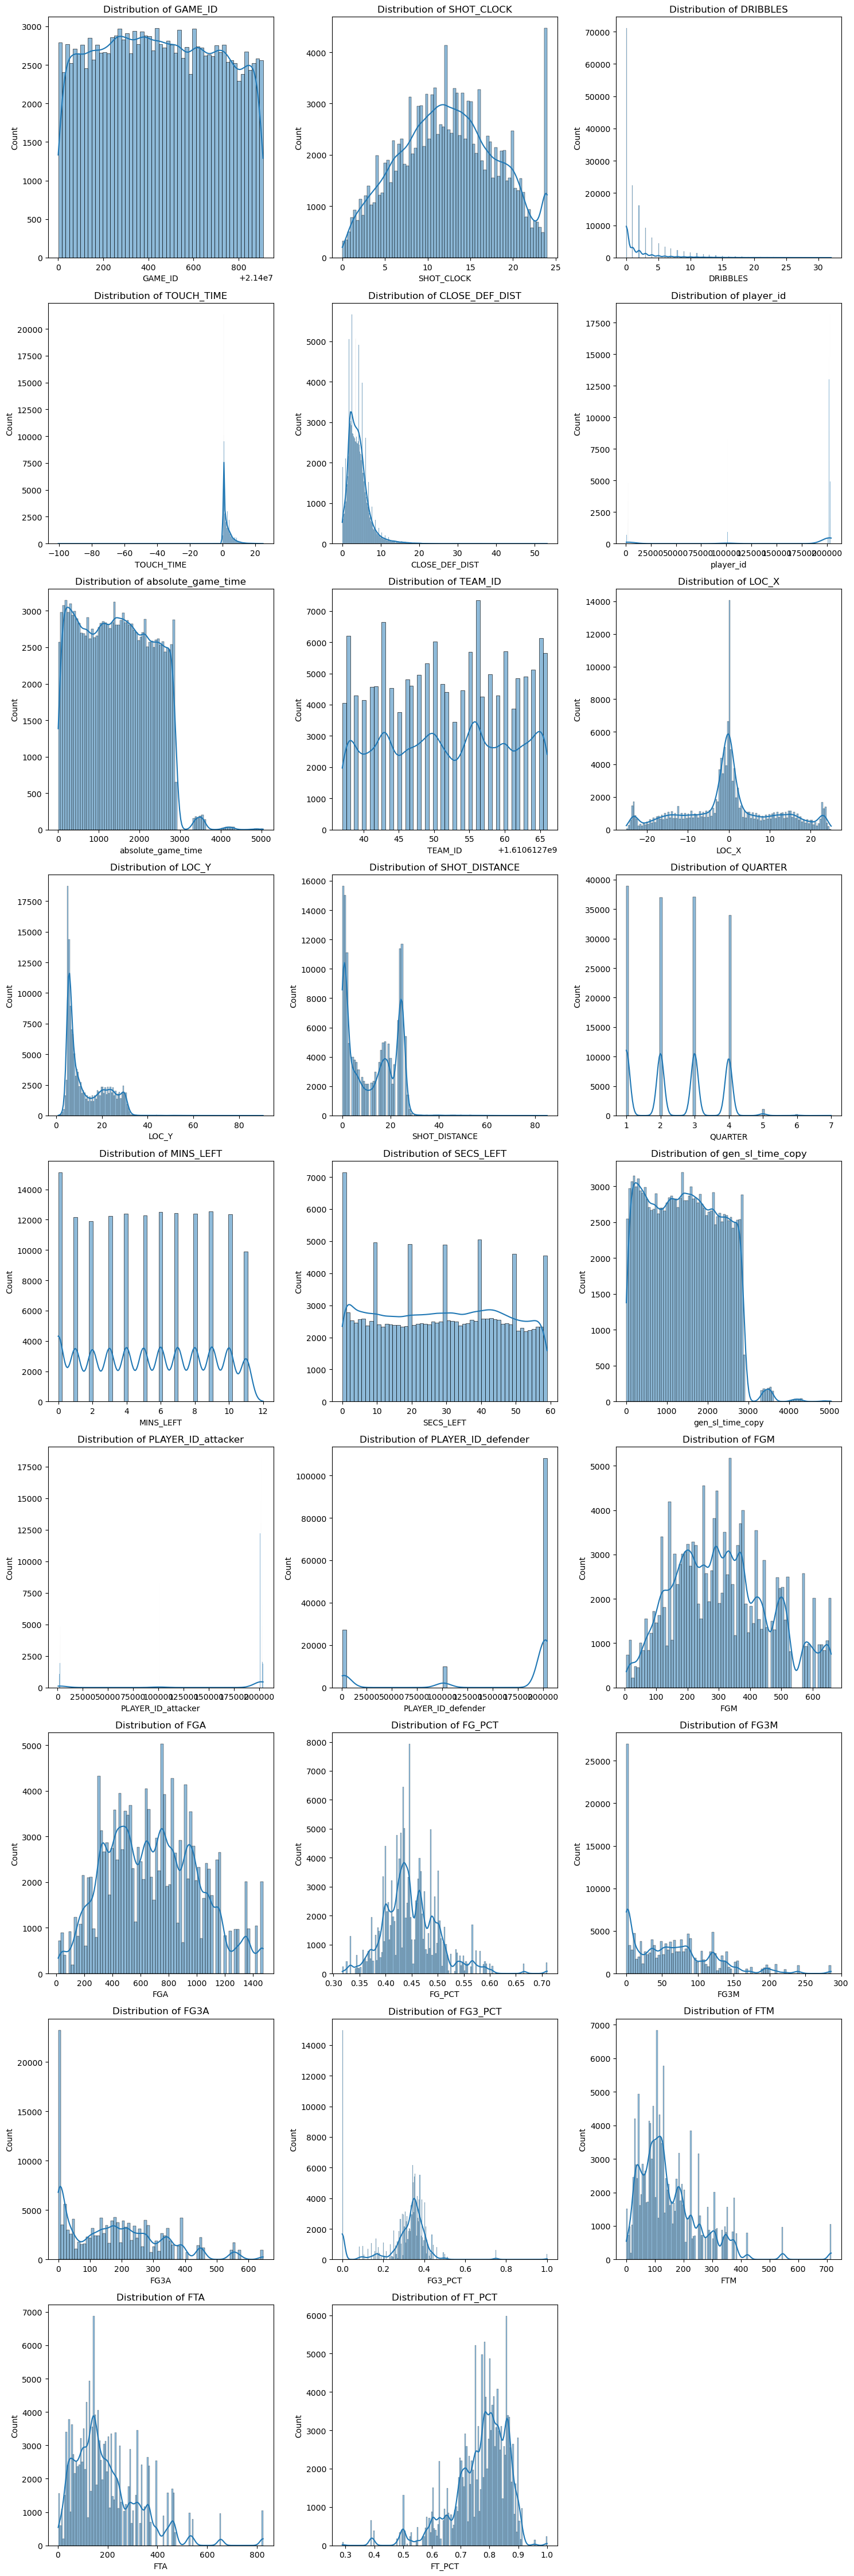

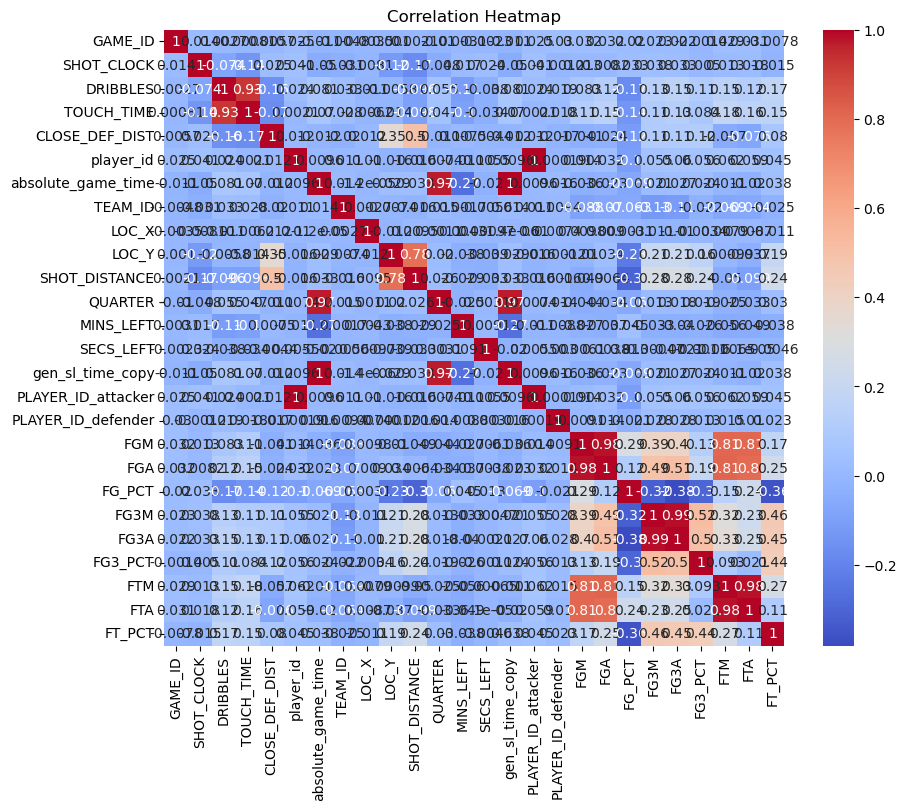

In [36]:
visualize_distributions(for_pred)

In [37]:
importlib.reload(du)
missing_summary = du.missing_values_summary(for_pred)
print(missing_summary)

                    Missing Values  Percentage
SHOT_CLOCK                    6320    4.263731
HEIGHT_defender               3674    2.478631
PLAYER_ID_defender            3062    2.065751
HEIGHT                         192    0.129531


In [38]:
# check for duplicate rows in the data for prediction
duplicate_rows = for_pred[for_pred.duplicated()]

# display the duplicate rows
print(duplicate_rows)

         GAME_ID  SHOT_CLOCK  DRIBBLES  TOUCH_TIME        CLOSEST_DEFENDER  \
2194    21400759        24.0         0         0.0          Anderson, Alan   
8032    21400587        24.0         0         0.0             West, David   
23571   21400620        22.5         0         0.0             Gibson, Taj   
72128   21400201        10.0         0         0.0          Morris, Marcus   
95863   21400086        24.0         0         0.0        Sullinger, Jared   
113995  21400019         8.5         0         1.0      Jefferson, Richard   
114335  21400834        21.5         2         2.5            Lopez, Brook   
120832  21400409        11.6         3         5.7            Green, Erick   
120833  21400409        11.6         3         5.7            Green, Erick   
120834  21400409        11.6         3         5.7            Green, Erick   
123718  21400276        12.0         2         3.3             Smith, J.R.   
125500  21400276        17.0         0         0.9             S

In [39]:
importlib.reload(du)
constant_columns = du.find_constant_columns(for_pred)
print("Columns with constant values:", constant_columns)

Columns with constant values: ['SEASON_1', 'SEASON_2']


In [40]:
# IMPLEMENT - DROP THE CONSTANT COLS, DEFINITELY SEASON_1
for_pred = for_pred.drop(['SEASON_1','SEASON_2','EVENT_TYPE'],axis =1)

In [41]:
for_pred

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,TEAM_ID,...,PLAYER_ID_defender,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,1.610613e+09,...,202709.0,225,455,0.495,10,29,0.345,79,126,0.627
1,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,1.610613e+09,...,201960.0,366,910,0.402,194,555,0.350,122,143,0.853
2,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,1.610613e+09,...,201565.0,512,1100,0.465,57,179,0.318,177,232,0.763
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,1.610613e+09,...,203095.0,363,831,0.437,140,391,0.358,130,160,0.813
4,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,1.610613e+09,...,201586.0,512,1100,0.465,57,179,0.318,177,232,0.763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148222,21400375,6.3,17,17.7,"Duncan, Tim",1495,5.0,201144,5017.0,1.610613e+09,...,1495.0,393,882,0.446,107,277,0.386,214,249,0.859
148223,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,1.610613e+09,...,1495.0,288,643,0.448,90,224,0.402,111,129,0.860
148224,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,1.610613e+09,...,203507.0,446,1025,0.435,121,337,0.359,141,176,0.801
148225,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,1.610613e+09,...,201188.0,251,589,0.426,89,258,0.345,147,204,0.721


In [42]:
for_pred.columns

Index(['GAME_ID', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id',
       'absolute_game_time', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
       'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'HOME_TEAM',
       'AWAY_TEAM', 'SHOT_MADE', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE',
       'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y',
       'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT',
       'gen_sl_time_copy', 'HEIGHT', 'PLAYER_ID_attacker', 'HEIGHT_defender',
       'PLAYER_ID_defender', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT'],
      dtype='object')

In [43]:
target_column = 'SHOT_MADE'

In [44]:
X = for_pred.drop(target_column, axis=1)
y = for_pred[target_column]

In [45]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [46]:
# Handle missing values

num_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

In [47]:
# Categorical imputer for missing values
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

In [48]:
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    X[col] = encoders[col].fit_transform(X[col])

In [49]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols]) # zero mean and unit variance for the numerical columns

In [50]:
X

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,TEAM_ID,...,PLAYER_ID_defender,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
0,0.071704,1.698113,-0.038701,-0.341942,242,0.552980,-0.658705,-1.993042,-1.678438,1.289143,...,0.571598,-0.562229,-0.715257,0.866139,-0.952083,-1.026384,0.330849,-0.663410,-0.516570,-1.521549
1,1.714633,1.787070,-0.038701,-0.112734,77,0.543463,-0.221213,-1.992812,-1.677262,-0.778461,...,0.562000,0.360073,0.682721,-0.890109,2.302935,2.556917,0.370121,-0.269516,-0.388779,0.872967
2,1.427895,1.662530,0.239865,0.116474,375,0.538445,0.435024,0.555566,-1.677262,0.485075,...,0.556939,1.315080,1.266493,0.299608,-0.120638,-0.004530,0.118783,0.234302,0.280244,-0.080601
3,-0.610266,1.537991,-0.595831,-0.505662,145,0.557884,-0.257671,0.565381,-1.677262,0.714809,...,0.576545,0.340449,0.439995,-0.229155,1.347658,1.439690,0.432955,-0.196234,-0.260988,0.449159
4,1.571264,1.449034,-0.595831,-0.931333,213,0.538712,-0.038925,0.555566,-1.677262,0.485075,...,0.557208,1.315080,1.266493,0.299608,-0.120638,-0.004530,0.118783,0.234302,0.280244,-0.080601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148222,-0.288655,-1.095126,4.139778,4.864353,127,-2.003498,0.325651,0.535821,4.218002,1.289143,...,-2.006853,0.536684,0.596692,-0.059196,0.763878,0.663081,0.652876,0.573234,0.408034,0.936539
148223,-0.288655,-2.091441,-0.317266,-0.243710,127,-2.003498,2.075616,0.541429,4.225058,1.289143,...,-2.006853,-0.150137,-0.137631,-0.021427,0.463142,0.302026,0.778545,-0.370280,-0.494018,0.947134
148224,-1.106245,0.000000,-0.595831,-0.669381,17,0.563118,-0.075383,-2.000014,4.233290,-0.089260,...,0.581824,0.883364,1.036057,-0.266924,1.011542,1.071823,0.440809,-0.095470,-0.140714,0.322017
148225,-0.288655,0.000000,1.911256,1.164282,155,0.533655,0.362108,-2.003443,4.239170,0.829676,...,0.552108,-0.392159,-0.303545,-0.436883,0.445452,0.533647,0.330849,-0.040508,0.069765,-0.525600


In [51]:
importlib.reload(du)
X_train, X_val, X_test, y_train, y_val, y_test = du.split_dataset(X, y, test_size=0.1, validation_size=0.2, random_state=2312)

In [52]:
X_train.columns

Index(['GAME_ID', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id',
       'absolute_game_time', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
       'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'HOME_TEAM',
       'AWAY_TEAM', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME',
       'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER',
       'MINS_LEFT', 'SECS_LEFT', 'gen_sl_time_copy', 'HEIGHT',
       'PLAYER_ID_attacker', 'HEIGHT_defender', 'PLAYER_ID_defender', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT'],
      dtype='object')

In [53]:
X_train.dropna()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,TEAM_ID,...,PLAYER_ID_defender,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
122342,-0.606391,-0.098811,-0.038701,-0.145478,192,0.533172,0.544396,0.541416,1.100439,-1.352796,...,0.551621,-0.130513,0.126602,-0.946762,1.029232,1.221695,0.291577,-0.205394,-0.328642,0.883563
2793,-0.552144,0.310389,-0.317266,-0.178222,122,0.539004,-1.059738,0.530862,-1.610230,-0.663594,...,0.557502,0.889906,0.768751,0.526220,2.409077,1.896118,1.053446,0.289264,0.062248,1.381537
112195,0.385566,0.000000,-0.595831,-0.931333,184,0.563042,-0.950366,-0.739037,0.854656,1.633744,...,0.581747,-1.504154,-1.523320,-0.512421,-1.128986,-1.223942,-2.378889,-1.011502,-0.930010,-2.051310
132559,-0.463023,-1.023961,-0.595831,-0.538406,150,-0.737837,0.070448,0.560983,1.353278,-1.697397,...,-0.730314,-0.719216,-0.721402,-0.096964,0.038575,0.084031,0.322995,-0.828296,-0.884908,0.226660
94654,-0.145286,0.096893,2.468387,2.375810,359,-1.991758,0.216278,0.550938,0.437177,1.174276,...,-1.995013,1.131928,1.226551,-0.078080,0.993852,1.024136,0.480081,2.048046,2.009178,0.438564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11108,-0.098788,1.395660,0.796995,0.836842,213,0.538712,0.726684,0.560511,-1.437359,0.599942,...,0.557208,1.825289,2.065338,-0.285808,2.338316,2.672727,0.315140,1.764076,1.528083,0.989515
69314,1.106284,-0.774882,-0.038701,0.607634,44,0.543667,-0.476417,0.541187,-0.120244,-1.237929,...,0.562205,0.176921,0.452285,-0.833455,0.215478,0.622207,-0.179681,0.005293,-0.058026,0.449159
56564,0.831171,0.808546,-0.317266,-0.374686,297,0.543654,0.179820,-0.738795,-0.409539,1.059409,...,0.562193,0.418943,0.738026,-0.852340,1.559942,1.821182,0.291577,1.727434,1.505532,0.957729
66835,-0.866005,0.826338,-0.038701,0.116474,125,0.557731,1.492294,0.565942,-0.179044,-0.318994,...,0.576391,0.471272,0.283299,0.790602,-1.005154,-0.924198,-1.130053,0.967127,1.144711,-0.313696


In [54]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Initialize the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=2312)

# Fit the model on the training data
logistic_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=2312)

In [56]:
logistic_model.score(X_train, y_train)

0.620943938982225

In [57]:
y_val_pred = logistic_model.predict(X_val)

In [58]:
y_val_pred = logistic_model.predict(X_val)

In [59]:
test_pred = logistic_model.predict(X_test)

In [60]:
accuracy_score(y_test, test_pred)

0.6180935033394049

In [61]:
accuracy_score(y_val, y_val_pred)

0.6204040328323526

Accuracy: 0.6204040328323526
Precision: 0.6070158805404124
Recall: 0.42919389978213507
F1 Score: 0.5028470449636756
ROC AUC: 0.6021673031832626


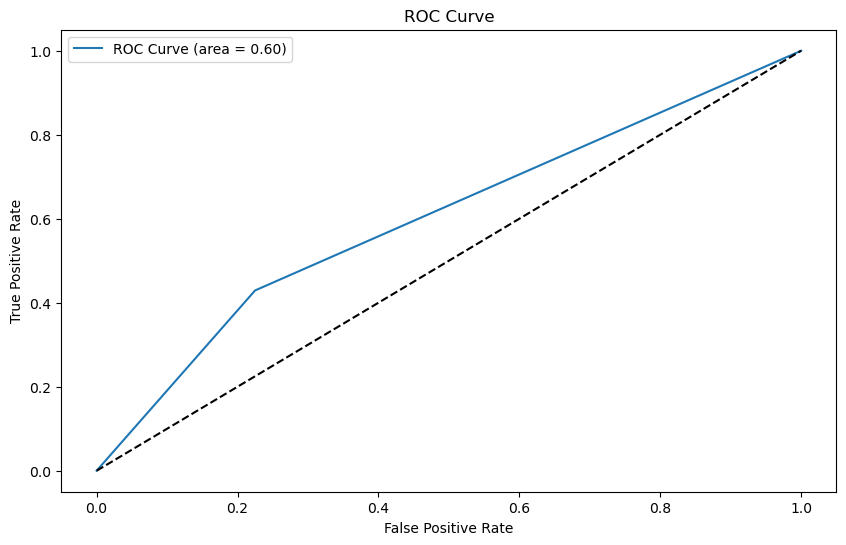

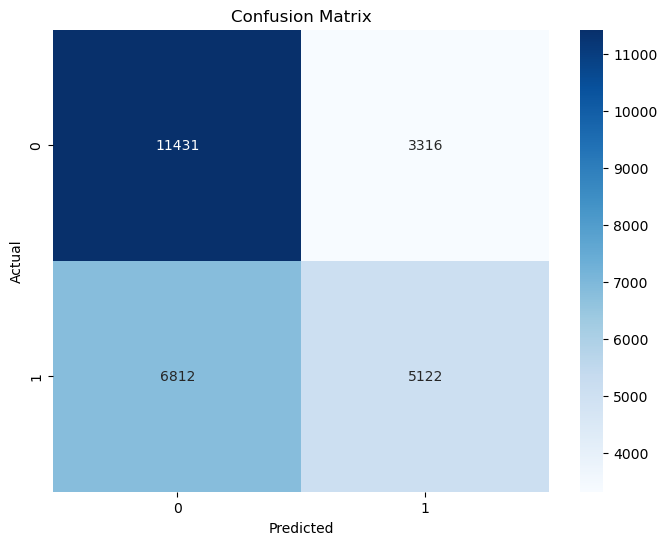

In [62]:


# Convert predicted probabilities to binary outcomes
y_val_pred_logistic_binary = (y_val_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [63]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Initialize the Ridge regression model
ridge_model = Ridge(alpha=1.0)

# Fit the model on the training data
ridge_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = ridge_model.predict(X_val)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on validation set: {mse}")

Mean Squared Error on validation set: 0.23165790055766838


In [64]:
y_val_pred > 0.5

array([False, False, False, ..., False,  True, False])

In [65]:
y_val

144845    0
129790    0
11420     0
81785     0
69876     1
         ..
103395    1
37385     0
37530     0
99031     1
19019     0
Name: SHOT_MADE, Length: 26681, dtype: int64

Precision: 0.6060139694566118
Recall: 0.4289425171778113
F1 Score: 0.5023306020313036
ROC AUC: 0.6363586614106161


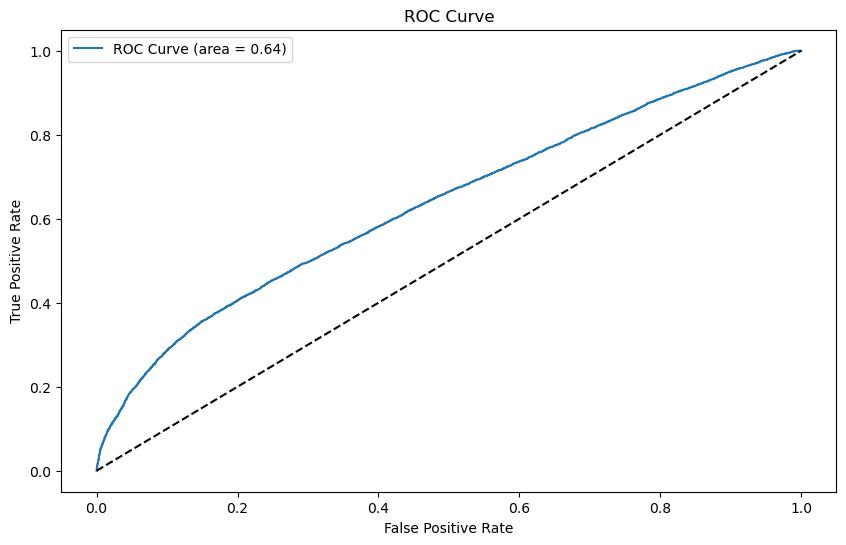

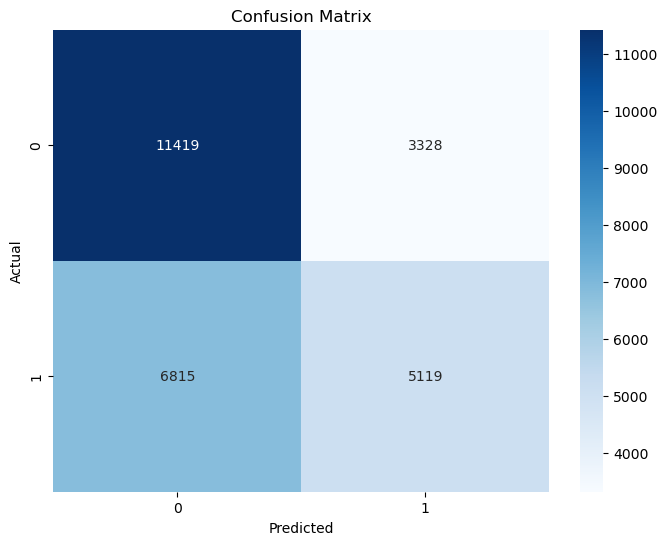

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Convert predicted probabilities to binary outcomes
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Calculate metrics
#accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_pred)

# Print metrics
#print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()